In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def rho_red_light(x, rho_max, rho_maxhold):
    """
    Computes the red light initial coniditon with shock
    
    Parameters
    ----------
    x: numpy.ndaray
        location on the road as a 1d array of floats
    rho_max : float
        The maximum traffic density allowed.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road as a 1d array of floats
    """
    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x < 3.0)
    rho[mask] = 0.5 * rho_maxhold
    return rho

In [4]:
nx = 81
L = 4.0
dx = L / (nx - 1)
nt = 40
rho_max = 10.0
rho_maxhold = 10.0
u_max = 1.0

x = numpy.linspace(0.0, L, num = nx)

rho0 = rho_red_light(x, rho_max, rho_maxhold)

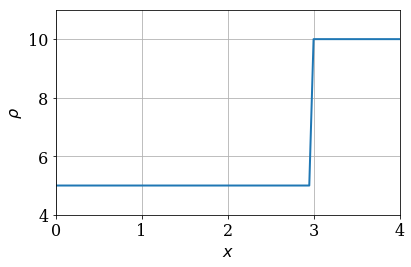

In [5]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                 color = 'C0', linestyle = '-', linewidth = 2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

In [6]:
def flux(rho, u_max, rho_max):
    F = rho * u_max * (1.0 - rho/rho_max)
    return F

In [7]:
from matplotlib import animation
from IPython.display import HTML

In [8]:
def update_plot(n, rho_hist):
    fig.suptitle('Time Step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [9]:
def lax_friedrichs(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = flux(rho, *args)
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) - dt / (2.0 * dx) * (F[2:] - F[:-2]))
        rho[0] = bc_values[0]
        rho[-1] = bc_values[1]
        rho_hist.append(rho.copy())
    return rho_hist

In [10]:
sigma = 1.0
dt = sigma * dx / u_max
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [11]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

The numerical solution appears to be slower than the exact solution, but there is minimal overshoot as compared to the next methods. The errors we are seeing are dispertave. The Lax-Friedrichs scheme appears to be a good tool for approximation but probably not worth the computing power as opposed to the next method.

In [12]:
sigma = 0.5
dt = sigma * dx / u_max
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [13]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

The solution with sigma 0.5 has more steps than sigma 1.0 but also appears to be faster. 

In [14]:
def jacobian(rho, u_max, rho_max):
    J = u_max * (1.0 - 2.0 * rho/rho_max)
    return J

In [15]:
def lax_wendroff(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = flux(rho, *args)
        J = jacobian(rho, *args)
        rho[1:-1] = (rho[1:-1] - 
                     dt / (2.0 * dx) * (F[2:] - F[:-2]) +
                     dt**2 / (4.0 * dx**2) * 
                     ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) - 
                      (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        rho[0] = bc_values[0]
        rho[-1] = bc_values[1]
        rho_hist.append(rho.copy())
    return rho_hist

In [16]:
sigma = 1.0
dt = sigma * dx / u_max
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [17]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

In [18]:
sigma = 0.5
dt = sigma * dx / u_max
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [19]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

The oscilations are due to the shock of the wave. With the initial shock creating a large overshoot, the wave can respond quicker, but with an increased overshoot. 

In [20]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        F = flux(rho, *args)
        rho_star[1:-1] = (rho[1:-1] -
                          dt / dx * (F[2:] - F[1:-1]))
        F = flux(rho_star, *args)
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] - 
                           dt / dx * (F[1:-1] - F[:-2]))
        rho[0] = bc_values[0]
        rho[-1] = bc_values[1]
        rho_hist.append(rho.copy())
    return rho_hist

In [21]:
sigma = 1.0
dt = sigma * dx / u_max
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [22]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

In [23]:
sigma = 0.5
dt = sigma * dx / u_max
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [24]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

The reversed mccormack was a more accurate method. See below

Dig Deeper Part 1

In [25]:
def maccormackreversed(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        F = flux(rho, *args)
        rho_star[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] - 
                           dt / dx * (F[1:-1] - F[:-2]))
        F = flux(rho_star, *args)
        rho[1:-1] = (rho[1:-1] -
                          dt / dx * (F[2:] - F[1:-1]))
        rho[0] = bc_values[0]
        rho[-1] = bc_values[1]
        rho_hist.append(rho.copy())
    return rho_hist

In [26]:
sigma = 1.0
dt = sigma * dx / u_max
rho_hist = maccormackreversed(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [27]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

In [28]:
sigma = 0.5
dt = sigma * dx / u_max
rho_hist = maccormackreversed(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [29]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

In our case, the best wave occured when the <br>predictor and the corrector were <br>reveresed and sigma was 0.5.<br> This was different from our ideal<br> case as the two results were vey similar

Challenge Task

In [39]:
nx = 81
L = 4.0
dx = L / (nx - 1)
nt = 40
rho_max = 10.0
rho_maxhold = 2.0
u_max = 1.0

x = numpy.linspace(0.0, L, num = nx)

rho0 = rho_red_light(x, rho_max, rho_maxhold)

In [40]:
sigma = 1.0
dt = sigma * dx / u_max
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [41]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

In [42]:
sigma = 0.5
dt = sigma * dx / u_max
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [43]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

In [45]:
sigma = 0.5
dt = sigma * dx / u_max
rho_hist = maccormackreversed(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in subtract
  # This is added back by InteractiveShellApp.init_path()


In [46]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

In [47]:
sigma = 0.5
dt = sigma * dx / u_max
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                         u_max, rho_max)

In [48]:
anim = animation.FuncAnimation(fig, update_plot, 
                               frames = nt, fargs = (rho_hist,),
                               interval = 100)
HTML(anim.to_html5_video())

As p_in decreases, the speed of the velocity shock <br> decreases. This happens because <br> the difference between the previous and the next steps is also decreasing.